In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c  # Typical exponential fit

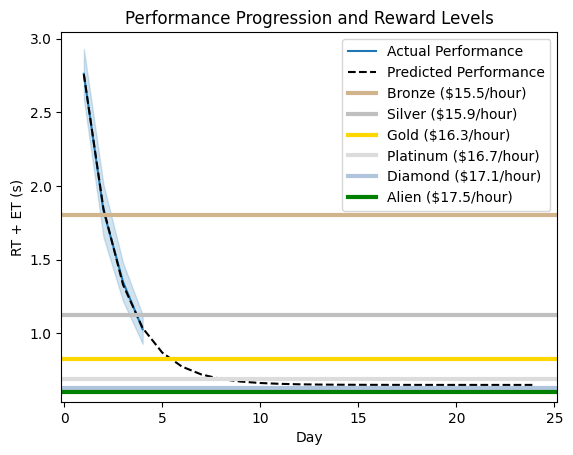

In [3]:
# Load data
data = pd.read_csv('/cifs/diedrichsen/data/Chord_exp/ExtFlexChord/efc2/metrics.tsv', sep='\t')

# Compute RT+ET
data['RT+ET'] = data['RT'] + data['ET']

# Filter trained chords and exclude day 5
data = data[(data['chord']=='trained') & (data['day']!=5)]
data_avg = data.groupby(['day', 'subNum']).mean(numeric_only=True).reset_index()

x = data_avg['day'].values
y = data_avg['RT+ET'].values

popt, _ = curve_fit(exp_func, x, y, p0=(max(y), -0.1, min(y)))

# Generate predicted curve
xhat = np.arange(24) + 1
yhat = exp_func(xhat, *popt)

# Define performance levels based on yhat max
max_performance = 3

num_levels = 6  # Number of levels
start = 0.6 * max_performance  # Initial threshold
end = 0.2 * max_performance  # Final threshold
exponents = np.linspace(0, 1, num_levels)  # Exponential spacing
decay_rate = 4

hrate = np.linspace(15.5, 17.5, 6)

thresholds = start - (start - end) * (1 - np.exp(-decay_rate * exponents)) / (1 - np.exp(-decay_rate))

# Compute exponentially decreasing thresholds
# thresholds = start * (end / start) ** exponents #[::-1]  # Reverse order

levels = {
    f"Bronze (${hrate[0]}/hour)": (thresholds[0] , 'tan'),
    f"Silver (${hrate[1]}/hour)": (thresholds[1] , 'silver'),
    f"Gold (${hrate[2]}/hour)": (thresholds[2] , 'gold'),
    f"Platinum (${hrate[3]}/hour)": (thresholds[3] , 'gainsboro'),
    f"Diamond (${hrate[4]}/hour)": (thresholds[4] , 'lightsteelblue'),
    f"Alien (${hrate[5]}/hour)": (thresholds[5] , 'green')
}

# Assign levels based on first day a participant crosses each threshold
rewards = []

for sub, sub_df in data_avg.groupby('subNum'):
    for level, threshold in levels.items():
        crossed_days = sub_df[sub_df['RT+ET'] <= threshold[0]]['day']
        if not crossed_days.empty:
            rewards.append({'subNum': sub, 'Level': level, 'DayReached': crossed_days.min()})

# Convert to DataFrame
df_rewards = pd.DataFrame(rewards)

# Plot performance with levels
sns.lineplot(data=data_avg, x='day', y='RT+ET', errorbar='se', label="Actual Performance")
plt.plot(xhat, yhat, label="Predicted Performance", linestyle="--", color="black")

# Add level lines
for level, threshold in levels.items():
    plt.axhline(y=threshold[0], lw=3, label=level, color=threshold[1])

plt.legend()
plt.xlabel("Day")
plt.ylabel("RT + ET (s)")
plt.title("Performance Progression and Reward Levels")
plt.show()